In [1]:
import pandas as pd
import numpy as np
import dask
from sklearn.pipeline import Pipeline


from dask.distributed import Client, LocalCluster
from dask_ml.model_selection import train_test_split


import joblib
from joblib import parallel_backend

import timeit

from dask_ml.model_selection import GridSearchCV
from dask_ml.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor


from dask_ml.wrappers import Incremental

from sklearn.metrics import mean_squared_error


from dask_ml.preprocessing import StandardScaler


from sklearn.pipeline import make_pipeline

from sklearn.linear_model import PassiveAggressiveRegressor

from sklearn.metrics import explained_variance_score

import dask.array as da

import matplotlib.pyplot as plt

import pickle

In [2]:
cluster = LocalCluster(threads_per_worker = 1, n_workers = 2)

client = Client(cluster)

In [3]:
client

Client Scheduler: tcp://127.0.0.1:51787 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 8.59 GB


In [4]:
df = pd.read_csv('large_cleaned_data.csv').drop('Unnamed: 0', 1)

In [5]:
# graphing a subset of the dataframe

In [99]:
plot_df = df[['Date','Open','Close']].copy()


In [100]:
plot_df['Date'] = plot_df['Date'].astype('datetime64')

In [101]:
plot_df['Date'] = plot_df.Date.apply(lambda x: x.year)

In [102]:
plot_df = plot_df.groupby('Date').median()



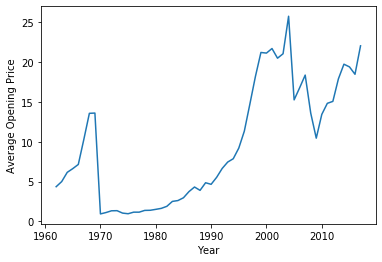

In [103]:
# the shape of the average opening price for the stock market over time

plt.plot(plot_df.index.values, plot_df.Open.values)
plt.ylabel('Average Opening Price')
plt.xlabel('Year')
plt.show()

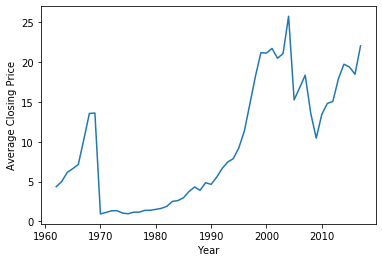

In [104]:
# the shape of the average closing price for the stock market over time

plt.plot(plot_df.index.values, plot_df.Close.values)
plt.ylabel('Average Closing Price')
plt.xlabel('Year')
plt.show()

In [ ]:
# the shape of the average opening and closing prices for stocks over time looks identical,
# so there is undoubtedly very strong correlation between the two features

In [11]:
# next the dataframe is split 

In [12]:
X, y = df.drop(['Date', 'Close'], 1), df[['Close']]

In [13]:
X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)


In [15]:
X_train_da = da.from_array(X_train.values, chunks = (1000000, 4))
y_train_da = da.from_array(y_train.values, chunks = (1000000, 1))

X_test_da = da.from_array(X_test.values, chunks = (1000000, 4))
y_test_da = da.from_array(y_test.values, chunks = (1000000, 1))

In [16]:
X_train_da, y_train_da = dask.persist(X_train_da, y_train_da)
X_test_da, y_test_da = dask.persist(X_test_da, y_test_da)

In [17]:
# all features except volume correlate highly with each other

df.corr(method = 'kendall')

,Open,High,Low,Close,Volume
Open,1.000000,0.990490,0.990079,0.987196,0.104118
High,0.990490,1.000000,0.985762,0.990741,0.105447
Low,0.990079,0.985762,1.000000,0.990574,0.102786
Close,0.987196,0.990741,0.990574,1.000000,0.104153
Volume,0.104118,0.105447,0.102786,0.104153,1.000000


In [18]:
# this correlation appears to be linear, so regression will model the relationships nicely

df.corr(method = 'pearson')

,Open,High,Low,Close,Volume
Open,1.000000,0.999713,0.999374,0.998930,-0.001689
High,0.999713,1.000000,0.999448,0.999476,-0.001686
Low,0.999374,0.999448,1.000000,0.999651,-0.001695
Close,0.998930,0.999476,0.999651,1.000000,-0.001690
Volume,-0.001689,-0.001686,-0.001695,-0.001690,1.000000


In [19]:

parameters = {'C': [.5,1,2]}

In [20]:
start = timeit.default_timer()
search = GridSearchCV(PassiveAggressiveRegressor(), parameters, cv = 3).fit(X_train_da, y_train_da.ravel())
end = timeit.default_timer()

print(end - start)

93.93058702899998


In [21]:
inc = Incremental(PassiveAggressiveRegressor(C=search.best_estimator_.get_params()['C']))

start = timeit.default_timer()
inc.fit(X_train_da, y_train_da.ravel())
end = timeit.default_timer()

print(end - start)

2.1314224810000155


In [22]:
# r2 score

inc.score(X_test_da, y_test_da)

0.9989535704084481

In [23]:
# explained variance score

explained_variance_score(y_test, inc.predict(X_test))

0.9991058586790001

In [24]:
# mean-squared error

mean_squared_error(y_test, inc.predict(X_test))

0.0010278464411771842

In [25]:
#####################################################
# let's try one variable since the scores are so high
#####################################################

In [26]:
X_train_da2 = da.from_array(X_train.Open.values.reshape(-1,1), chunks = (1000000, 1))

X_test_da2 = da.from_array(X_test.Open.values.reshape(-1,1), chunks = (1000000, 1))

In [27]:
X_train_da2, X_test_da2 = dask.persist(X_train_da2, X_test_da2)

In [28]:
start = timeit.default_timer()
search2 = GridSearchCV(PassiveAggressiveRegressor(), parameters, cv = 3).fit(X_train_da2, y_train_da.ravel())
end = timeit.default_timer()

print(end - start)

83.72361901700003


In [29]:
inc2 = Incremental(PassiveAggressiveRegressor(C=search2.best_estimator_.get_params()['C']))

start = timeit.default_timer()
inc2.fit(X_train_da2, y_train_da.ravel())
end = timeit.default_timer()

print(end - start)

1.7483433090000062


In [30]:
# r2 score

inc2.score(X_test_da2, y_test_da)

0.7084704295718254

In [31]:
# explained variance score

explained_variance_score(y_test, inc2.predict(X_test.Open.values.reshape(-1,1)))

0.82537518823922

In [32]:
# mean-squared error

mean_squared_error(y_test, inc2.predict(X_test.Open.values.reshape(-1,1)))

0.2863524062026131

In [33]:
# one variable seems to suffice
# let's check the results on a different data set
# the model was trained on data from 2005 to 2010
# let's train it on 

In [34]:
df2 = pd.read_csv('cleaned_data.csv').rename(columns = {'Unnamed: 0':'date'})

In [89]:
df2.date = pd.to_datetime(df2.date)

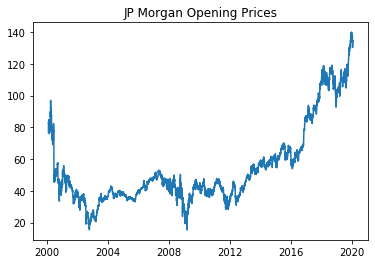

In [154]:
# JP Morgan Opening prices
plt.plot(df2.date, df2.open)
plt.title('JP Morgan Opening Prices')
plt.show()

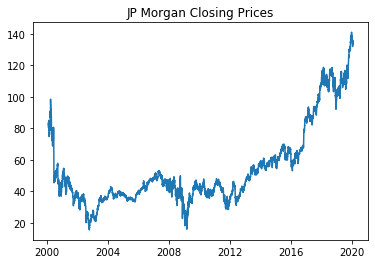

In [153]:
# JP Morgan Closing prices
plt.plot(df2.date, df2.close)
plt.title('JP Morgan Closing Prices')
plt.show()

In [ ]:
# the opening and closing prices for JP Morgan from 2000 to 2020 look identical

In [35]:
import re
matches = {i:re.search('2018.*', df2.date[i]) for i in range(len(df2.date)) 
           if re.search('2018.*', df2.date[i]) is not None}


In [38]:
# explained variance score

explained_variance_score(df2.close.values[list(matches.keys())[0]:list(matches.keys())[-1]+1], 
                         inc2.predict(df2[list(matches.keys())[0]:list(matches.keys())[-1]+1]
                                      .open.values.reshape(-1,1)))

0.7700712535708589

In [ ]:
# The model was trained on data from 2005 to 2010,
# but making predictions on stock market data for J.P. Morgan in 2018 from another data set 
# still gives a decent score for explained variance

In [139]:
df2['predictions'] = inc2.predict(df2.open.values.reshape(-1, 1))

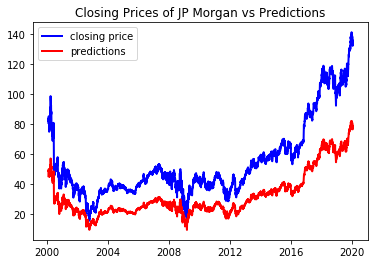

In [158]:
plt.plot('date', 'close', data=df2, marker='', color='blue', linewidth=2, 
         label='closing price')
plt.plot('date', 'predictions', data=df2, marker='', color='red', linewidth=2, 
         label="predictions")
plt.legend()
plt.title('Closing Prices of JP Morgan vs Predictions')
plt.show()

In [151]:
explained_variance_score(df2.close.values, 
                         df2.predictions)

0.8252379945348933

In [ ]:
# It seems as though the shape of the closing price matches the shape of the predictions 
# of the model, but the predictions are off by a factor
# Let's adjust the predictions

In [140]:
df2['predictions2'] = df2['predictions'].map(lambda x: x*(1.5))

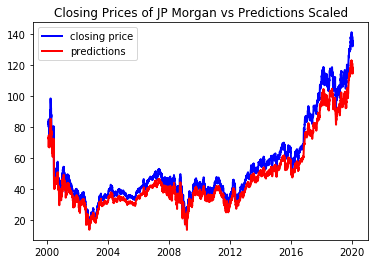

In [157]:
plt.plot('date', 'close', data=df2, marker='', color='blue', linewidth=2, 
         label='closing price')
plt.plot('date', 'predictions2', data=df2, marker='', color='red', linewidth=2, 
         label="predictions")
plt.legend()
plt.title('Closing Prices of JP Morgan vs Predictions Scaled')
plt.show()

In [152]:
explained_variance_score(df2.close.values, 
                         df2.predictions2)

0.9831128321281458

In [ ]:
# the explained variance score went up dramatically when the predictions were scaled
# the new data set may just be scaled differently than the data set the model was trained on

In [ ]:
# finally, the data is pickled to prepare it for the flask application

In [39]:
import pickle
with open('model.pkl', 'wb') as fid:
    pickle.dump(inc2, fid, 2) 